In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)
import numpy as np
import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle
np.random.seed(1515)

In [33]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config) 
    
import keras 
from keras.backend.tensorflow_backend import set_session
set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Reshape, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [38]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [39]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [48]:
def build_crnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(5, 5), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    # CONV 4
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,5), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    y = Reshape((n_frames, n_filters_cnn))(y)
    
    #y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    #y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [49]:
m = build_crnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 173, 40, 48)       1248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 173, 20, 48)       0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 173, 20, 48)       192       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 173, 20, 48)       57648     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 173, 10, 48)       0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 173, 10, 48)       192       
__________

In [50]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'crnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 45s 6ms/step - loss: 2.7083 - acc: 0.3652 - val_loss: 2.9803 - val_acc: 0.2059
Epoch 2/200
7079/7079 [==============================] - 42s 6ms/step - loss: 1.9166 - acc: 0.5207 - val_loss: 3.4920 - val_acc: 0.1348
Epoch 3/200
7079/7079 [==============================] - 42s 6ms/step - loss: 1.8494 - acc: 0.5389 - val_loss: 2.7877 - val_acc: 0.2451
Epoch 4/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.8684 - acc: 0.5488 - val_loss: 2.6291 - val_acc: 0.2892
Epoch 5/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.8889 - acc: 0.5481 - val_loss: 2.9051 - val_acc: 0.2721
Epoch 6/200
7079/7079 [==============================] - 34s 5ms/step - loss: 2.0844 - acc: 0.4802 - val_loss: 2.6530 - val_acc: 0.3517
Epoch 7/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.7067 - acc: 0.6079 - val_loss: 2.4068 - val_acc: 0.4020
E

7079/7079 [==============================] - 24s 3ms/step - loss: 0.9053 - acc: 0.8715 - val_loss: 2.0619 - val_acc: 0.5980
Epoch 61/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.8925 - acc: 0.8662 - val_loss: 2.2065 - val_acc: 0.5319
Epoch 62/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.9701 - acc: 0.8429 - val_loss: 1.9007 - val_acc: 0.6054
Epoch 63/200
7079/7079 [==============================] - 23s 3ms/step - loss: 0.9571 - acc: 0.8518 - val_loss: 1.9375 - val_acc: 0.6017
Epoch 64/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.8441 - acc: 0.8761 - val_loss: 1.8568 - val_acc: 0.6618
Epoch 65/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.8038 - acc: 0.8822 - val_loss: 2.0877 - val_acc: 0.6042
Epoch 66/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.7353 - acc: 0.8890 - val_loss: 1.9295 - val_acc: 0.6017
Epoch 67/200
7079/7079 [==============================

In [17]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 992us/step


Accuracy: 0.71


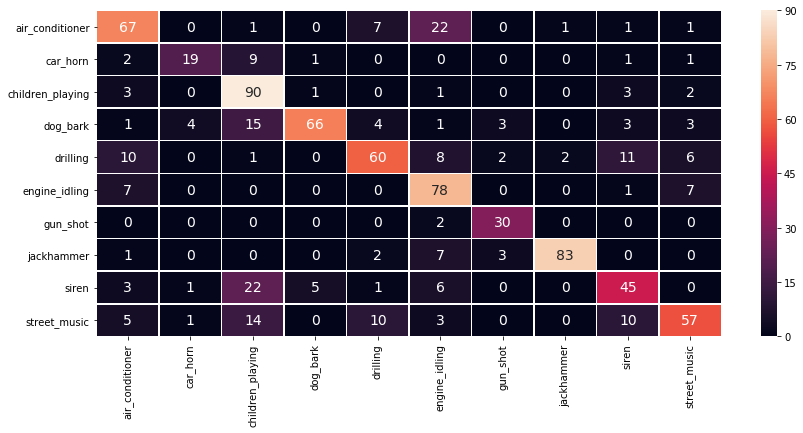

In [20]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)

In [ ]:
def build_crnn2(n_features=n_features, n_frames=n_frames, n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_features, n_frames, 1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)
    
    y = TimeDistributed(Flatten())(y)
    
    #y = Reshape((n_filters_cnn,n_frames))(y)
    
    y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [36]:
m = build_crnn2(n_features=40,)
m.summary()

AttributeError: 'Tensor' object has no attribute 'T'